In [59]:
import jax 
import jax.numpy as jnp
import math
from jax import jit, vmap
from functools import partial, lru_cache
from src.models.vsh_model import*
from jax import random
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

In [102]:
df = load_5p_data()
angles, obs, error = config_data(df)


In [103]:
print(jnp.min(obs[0]), jnp.max(obs[0]))
print(jnp.min(obs[1]), jnp.max(obs[1]))

-1368.3303 1195.4039
-986.4631 1010.71436


In [104]:
print(jnp.min(error[0]), jnp.max(error[0]))
print(jnp.min(error[1]), jnp.max(error[1]))

0.97243935 330.97748
1.291789 338.21484


In [91]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-10., 10.).expand([total_params]))

    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [92]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.75)
rng_key = jax.random.key(0)
numpyro.set_host_device_count(2)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=2, progress_bar=True)
mcmc.run(rng_key, angles=angles, obs=obs, error=error, lmax=2)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_29499/77864599.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=2, progress_bar=True)
warmup:  11%|█         | 438/4000 [00:43<05:56,  9.99it/s, 7 steps of size 6.74e-01. acc. prob=0.74]  


KeyboardInterrupt: 

In [35]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]     -0.00      0.00     -0.00     -0.00     -0.00   5447.69      1.00
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.00   4795.49      1.00
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.01   7687.13      1.00
  theta[3]      0.00      0.00      0.00      0.00      0.01   6026.91      1.00
  theta[4]      0.00      0.00      0.00      0.00      0.01   5142.31      1.00
  theta[5]     -0.01      0.00     -0.01     -0.01     -0.01   8780.23      1.00
  theta[6]      0.01      0.00      0.01      0.00      0.01   4814.40      1.00
  theta[7]     -0.00      0.00     -0.00     -0.00     -0.00   5693.77      1.00
  theta[8]      0.00      0.00      0.00     -0.00      0.00   5481.01      1.00
  theta[9]      0.00      0.00      0.00      0.00      0.01   5051.60      1.00
 theta[10]      0.01      0.00      0.01      0.01      0.01   3754.23      1.00
 theta[11]      0.01      0

In [36]:
parameters = jnp.mean(posterior_sample['theta'], axis=0)

In [37]:
parameters

Array([-0.00169466, -0.00632678, -0.00933125,  0.00493235,  0.00281017,
       -0.00979357,  0.00614095, -0.00360828,  0.00146974,  0.00383913,
        0.0071694 ,  0.0066481 , -0.0046057 ,  0.0047964 , -0.00497876,
        0.00526761], dtype=float32)

In [38]:
index = get_vsh_index_map(5)
for i in [0,2,3,1,4,5]:
    print(f'{index[i]} = {parameters[i]:.5f}, index = {i}')

t_10 = -0.00169, index = 0
t_11r = -0.00933, index = 2
t_11i = 0.00493, index = 3
s_10 = -0.00633, index = 1
s_11r = 0.00281, index = 4
s_11i = -0.00979, index = 5


In [39]:
param = jnp.array([parameters[1], parameters[4], parameters[5]])
cov_slm, _, cov_matrix = cov_matrix_hmc(posterior_sample)
summary_equatorial, g_vec, Sigma_g = vsh_vector_summary(param, cov_slm)

In [40]:
print(parameters)
print(param)

[-0.00169466 -0.00632678 -0.00933125  0.00493235  0.00281017 -0.00979357
  0.00614095 -0.00360828  0.00146974  0.00383913  0.0071694   0.0066481
 -0.0046057   0.0047964  -0.00497876  0.00526761]
[-0.00632678  0.00281017 -0.00979357]


In [41]:
summary_equatorial

{'|g| (μas/yr)': Array(5.437011, dtype=float32),
 'g (μas/yr)': Array([-1.3730539, -4.785165 , -2.1858656], dtype=float32),
 '|sigma_g| (μas/yr)': Array(0.22540908, dtype=float32),
 'sigma_g (μas/yr)': Array([0.66025776, 0.09914982, 0.30857253], dtype=float32),
 'Corr_gx_gy': Array(-0.01184584, dtype=float32),
 'Corr_gx_gz': Array(-0.00017933, dtype=float32),
 'Corr_gy_gz': Array(0.01635787, dtype=float32)}

In [42]:
max(parameters)

Array(0.0071694, dtype=float32)

In [43]:
diag_hmc = jnp.diag(cov_matrix)
limits = {}
idx = 0
for i in range(0, len(diag_hmc)+1):
    limits[f'x{idx}'] = (parameters[i]-1000*diag_hmc[i], parameters[i]+1000*diag_hmc[i])
    idx +=1

In [15]:
lmax = 2
total_params = count_vsh_coeffs(lmax) 
limits = vsh_minuit_limits(lmax, t_bound=.08, s_bound=.08)


# Flat vector theta: [t10, ..., t_lmaxm, s10, ..., s_lmaxm]
theta_init = jnp.zeros(total_params)#parameters[:total_params] # initial points from HMC

# Fix everything except theta
#bound_least_square = partial(least_square, data, obs, error, lmax=lmax, grid=False)

def least_square_wrapper(*theta_flat):
    theta = jnp.array(theta_flat)  # reconstructs the vector from scalars
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)


m = Minuit(least_square_wrapper, *theta_init)

m.errordef = Minuit.LEAST_SQUARES
for i, name in enumerate(m.parameters):
    m.limits[name] = limits[name]


m.migrad()
m.params

NameError: name 'angles' is not defined

In [94]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.728e+06                  │             Nfcn = 3470              │
│ EDM = 0.706 (Goal: 0.0002)       │           time = 12.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   -0.21   │   0.10    │            │            │   -80   │   80    │       │
│ 1 │ x1   │   -0.64   │   0.09    │            │            │   -80   │   80    │       │
│ 2 │ x2   │   -1.12   │   0.13    │            │            │   -80   │   80    │       │
│ 3 │ x3   │   0.51    │   0.12    │            │            │   -80   │   80    │       │
│ 4 │ x4   │   0.27    │   0.14    │            │            │   -80   │   80    │       │
│ 5 │ x5   │   -1.73   │   0.13    │            │            │   -80   │   80    │       │
│ 6 │ x6   │   0.42    │   0.09    │            │            │   -80   │   80    │       │
│ 7 │ x7   │   -0.35   │   0.08    │            │            │   -80   │   80    │       │
│ 8 │ x8   │   0.17    │   0.13    │            │            │   -80   │   80    │       │
│ 9 │ x9   │   0.39    │   0.13    │            │            │   -80   │   80    │       │
│ 10│ x10  │   0.74    │   0.12    │            │            │   -80   │   80    │       │
│ 11│ x11  │   0.70    │   0.13    │            │            │   -80   │   80    │       │
│ 12│ x12  │   -0.30   │   0.12    │            │            │   -80   │   80    │       │
│ 13│ x13  │   0.39    │   0.12    │            │            │   -80   │   80    │       │
│ 14│ x14  │   -0.50   │   0.13    │            │            │   -80   │   80    │       │
│ 15│ x15  │   0.57    │   0.13    │            │            │   -80   │   80    │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│     │      x0      x1      x2      x3      x4      x5      x6      x7      x8      x9     x10     x11     x12     x13     x14     x15 │
├─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│  x0 │  0.0091   0.000   0.002  -0.002  -0.001   0.000  -0.000   0.000  -0.000  -0.001   0.001   0.002  -0.000  -0.000   0.001   0.002 │
│  x1 │   0.000 0.00758   0.001  -0.000  -0.000  -0.000  -0.000  -0.000  -0.002  -0.003  -0.000  -0.001  -0.000  -0.002   0.000   0.000 │
│  x2 │   0.002   0.001   0.016  -0.000  -0.000  -0.000  -0.000  -0.001  -0.001  -0.000  -0.001  -0.002  -0.001  -0.001  -0.001  -0.003 │
│  x3 │  -0.002  -0.000  -0.000  0.0145   0.000  -0.000   0.000  -0.003   0.000  -0.000  -0.002  -0.001   0.000  -0.000   0.003  -0.001 │
│  x4 │  -0.001  -0.000  -0.000   0.000  0.0187   0.001   0.003   0.000   0.000   0.005  -0.000   0.000   0.003   0.004  -0.001  -0.001 │
│  x5 │   0.000  -0.000  -0.000  -0.000   0.001  0.0165   0.004   0.000  -0.000   0.000  -0.000  -0.000  -0.003   0.002   0.000  -0.000 │
│  x6 │  -0.000  -0.000  -

In [95]:
m.fmin.is_valid

False

In [96]:
cov_slm_iminuit, _, _ = cov_matrix_minuit(m.covariance)
parame_iminuit = jnp.array([m.values[k] for k in m.parameters])

In [97]:
param_m = jnp.array([parame_iminuit[1], parame_iminuit[4], parame_iminuit[5]])

In [98]:
summary_iminuit, g_vec_im, Sigma_g_im = vsh_vector_summary(param_m, cov_slm_iminuit)
summary_iminuit

{'|g| (μas/yr)': Array(884.5348, dtype=float32),
 'g (μas/yr)': Array([-130.4742 , -846.7209 , -220.09552], dtype=float32),
 '|sigma_g| (μas/yr)': Array(60.897095, dtype=float32),
 'sigma_g (μas/yr)': Array([66.865776, 62.747753, 30.08553 ], dtype=float32),
 'Corr_gx_gy': Array(-0.03614026, dtype=float32),
 'Corr_gx_gz': Array(0.01933538, dtype=float32),
 'Corr_gy_gz': Array(-0.01416517, dtype=float32)}

In [106]:
ra_dec_im = alpha_delta_summary(g_vec_im, Sigma_g_im)
ra_dec_im

{'RA (deg)': Array(261.24002, dtype=float32),
 'Sigma_RA (deg)': Array(2.218604, dtype=float32),
 'Dec (deg)': Array(-14.408071, dtype=float32),
 'Sigma_Dec (deg)': Array(2.218604, dtype=float32),
 'Corr_RA_dec': Array(0.7113742, dtype=float32)}

# Generated Data Experiment.

Generating fake data for $l_{max}=2$ to then fit the data for $l=1,2,3$, what we aim to show is that, for the $l=2$ least square fit we will recover the right parameters and the function will be at its mimimum, while when performing the least square fit for VSH function with $l=1$ and $l=3$ we will recover the dominant parmaters, however the function will not be at the minimum.

In [3]:
import jax 
import jax.numpy as jnp
import numpy as np
from src.models.vsh_model import*
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist
from tqdm import tqdm
import gc

/root/Document/Gaia_Project/mem97/gaia_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load fake data

In [4]:
vsh_coeff_gen = np.load('fake_data/vsh_gen_cov.npy') # Load true coefficient values

fake_data = pd.read_csv('fake_data/fake_vsh_data.csv')
angles_gen, obs_gen, error_gen = config_data(fake_data)

Run HMC to find a initial guest of the parameter to feed to imimuit

In [66]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    theta = numpyro.sample("theta", dist.Uniform(-0.08, 0.08).expand([total_params]))
    chi2_val = chi2_jit(angles, obs, error, theta, lmax) 
    numpyro.factor("likelihood", -0.5*chi2_val)


In [67]:
kernel = NUTS(model_for_HMC, target_accept_prob=0.75)
rng_key = jax.random.key(0)
numpyro.set_host_device_count(2)
mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)
mcmc.run(rng_key, angles=angles_gen, obs=obs_gen, error=error_gen, lmax=2)

posterior_sample = mcmc.get_samples()

/tmp/ipykernel_22239/2619420033.py:4: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)
sample:  38%|███▊      | 803/2100 [01:22<02:12,  9.76it/s, 63 steps of size 3.81e-02. acc. prob=0.95] 


KeyboardInterrupt: 

In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.05      0.00      0.05      0.05      0.05   1762.72      1.00
  theta[1]      0.06      0.00      0.06      0.05      0.06   2951.01      1.00
  theta[2]     -0.02      0.00     -0.02     -0.02     -0.02   2149.80      1.00
  theta[3]     -0.00      0.00     -0.00     -0.00     -0.00   3086.96      1.00
  theta[4]      0.01      0.00      0.01      0.01      0.02   1446.65      1.00
  theta[5]     -0.04      0.00     -0.04     -0.04     -0.04   3454.74      1.00
  theta[6]     -0.02      0.00     -0.02     -0.02     -0.01   1442.78      1.00
  theta[7]      0.02      0.00      0.02      0.02      0.03   1903.33      1.00
  theta[8]      0.03      0.00      0.03      0.03      0.03   1528.86      1.00
  theta[9]     -0.04      0.00     -0.04     -0.04     -0.03   2217.34      1.00
 theta[10]      0.06      0.00      0.06      0.06      0.06   3187.32      1.00
 theta[11]     -0.06      0

In [6]:
jnp.std(posterior_sample['theta'], axis=0)

Array([0.00088651, 0.00086876, 0.00254539, 0.00067689, 0.00254179,
       0.00069147, 0.0024203 , 0.00244607, 0.00129023, 0.0022534 ,
       0.0012672 , 0.0022979 , 0.00104722, 0.00086756, 0.00100339,
       0.00085477], dtype=float32)

$l_{max}=2$ `iminuit.Minuit` least square fit

In [ ]:
lmax = 2
total_params = count_vsh_coeffs(lmax) 
limits = vsh_minuit_limits(lmax, t_bound=0.08, s_bound=0.08)


# Flat vector theta: [t10, ..., t_lmaxm, s10, ..., s_lmaxm]
theta_init = jnp.zeros(total_params)

def least_square_wrapper(*theta_flat):
    theta = jnp.array(theta_flat)  # reconstructs the vector from scalars
    return least_square(angles_gen, obs_gen, error_gen, theta, lmax=lmax, grid=False)


m = Minuit(least_square_wrapper, *theta_init)

m.errordef = Minuit.LEAST_SQUARES
for i, name in enumerate(m.parameters):
    m.limits[name] = limits[name]

m.migrad()
theta_fit = jnp.array([m.values[k] for k in m.parameters])
print("Fitted parameters values:")
print(theta_fit)
print("Sampled from HMC:")
print(jnp.mean(posterior_sample['theta'], axis=0))
print("True values:")
print(vsh_coeff_gen)
print('Is the function minimum valid?', m.fmin.is_valid)

Fitted parameters values:
[ 0.05249041  0.05554223 -0.02023    -0.00364052  0.01248626 -0.0390929
 -0.01700586  0.02229834  0.03157498 -0.0358141   0.05911672 -0.06064666
  0.01466664  0.00676478  0.04517596  0.052738  ]
Sampled from HMC:
True values:
[ 0.05372004  0.05742959 -0.02012502 -0.00375978  0.00838665 -0.04013964
 -0.02277664  0.02273766  0.02961199 -0.03947825  0.05824246 -0.05696608
  0.01680502  0.0075229   0.04790566  0.0521445 ]
Is the function minimum valid? False


Coefficients that we care abaut are $s_{10}$, $s_{11}^{\real}$ and $s_{11}^{i}$

In [8]:
index_val = get_vsh_index_map(lmax)
print(f'Index {1} : {index_val[1]}')
print(f'Index {4} : {index_val[4]}')
print(f'Index {5} : {index_val[5]}')

Index 1 : s_10
Index 4 : s_11r
Index 5 : s_11i


In [ ]:
hmc_coef = jnp.mean(posterior_sample['theta'], axis=0)
hmc_std = jnp.std(posterior_sample['theta'], axis=0)

im_var = jnp.sqrt(jnp.diag(m.covariance))

In [10]:
print('Comparisons:')
print('Least Square fit:')
print(f"""s_10 = {theta_fit[1]} +/- {im_var[1]}, s_11r = {theta_fit[4]} +/- {im_var[4]} 
      and s_11i = {theta_fit[5]} +/- {im_var[5]}""")
print('HMC sampling result:')
print(f"""s_10 = {hmc_coef[1]} +/- {hmc_std[1]}, s_11r = {hmc_coef[4]} +/- {hmc_std[4]} 
      and s_11i = {hmc_coef[5]} +/- {hmc_std[5]}""")
print("True values:")
print(f"""s_10 = {vsh_coeff_gen[1]}, s_11r = {vsh_coeff_gen[4]} and s_11i = {vsh_coeff_gen[5]}""")

Comparisons:
Least Square fit:
s_10 = 0.0555422306060791 +/- 6.136519346000568e-07, s_11r = 0.01248625572770834 +/- 2.934761141659692e-05 
      and s_11i = -0.03909290209412575 +/- 9.823775144468527e-07
HMC sampling result:
s_10 = 0.055638715624809265 +/- 0.029474686831235886, s_11r = 0.011668037623167038 +/- 0.050416141748428345 
      and s_11i = -0.0391148142516613 +/- 0.026295771822333336
True values:
s_10 = 0.057429585605859756, s_11r = 0.008386645466089249 and s_11i = -0.040139637887477875


Running sampling on fake data for $l_{max}=1,2,3$.

First HMC:

In [11]:
posterior_samples = []
rng_key = jax.random.key(0)

for i in range(1,4):
    
    kernel = NUTS(model_for_HMC, target_accept_prob=0.75)
    numpyro.set_host_device_count(2)
    mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)
    mcmc.run(rng_key, angles=angles_gen, obs=obs_gen, error=error_gen, lmax=i)

    posterior_sample = mcmc.get_samples()
    
    posterior_samples.append(posterior_sample)

/tmp/ipykernel_1140/3530956422.py:8: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)
sample: 100%|██████████| 2100/2100 [44:28<00:00,  1.27s/it, 1023 steps of size 6.80e-03. acc. prob=0.85]


In [12]:
coef_pred = [jnp.mean(ps['theta'], axis=0) for ps in posterior_samples]
std_pred = [jnp.std(ps['theta'], axis=0) for ps in posterior_samples]

In [15]:
import numpy as np

coef_pred_np = np.array([np.array(x) for x in coef_pred], dtype=object)
std_pred_np = np.array([np.array(x) for x in std_pred], dtype=object)

np.savez('fake_data/posterior_summary.npz', coef=coef_pred_np, std=std_pred_np)


Then `iminuit`.

In [37]:
def eval_loss(theta, lmax):
    return least_square(angles_gen, obs_gen, error_gen, theta, lmax=lmax, grid=False)
eval_loss = jit(eval_loss, static_argnames=['lmax'])

def run_iminuit(lmax, t_bound, s_bound):

    def least_square_wrapper(*theta_flat):
        theta = jnp.array(theta_flat)
        return float(eval_loss(theta, lmax)) 

    total_params = count_vsh_coeffs(lmax) 
    limits = vsh_minuit_limits(lmax, t_bound=t_bound, s_bound=s_bound)
    
    theta_init = jnp.zeros(total_params)    

    m = Minuit(least_square_wrapper, *theta_init)

    m.errordef = Minuit.LEAST_SQUARES
    for i, name in enumerate(m.parameters):
        m.limits[name] = limits[name]

    m.migrad()

    return m

In [38]:
m = run_iminuit(3, 0.08, 0.08)

In [41]:
print(jnp.sqrt(jnp.diag(m.covariance)))

[0.00061001 0.00094115 0.00105731 0.0025324  0.00306712 0.00222983
 0.00217035 0.00162861 0.0013746  0.00333035 0.00110783 0.00055441
 0.00123883 0.00078152 0.00104788 0.00069853 0.00058112 0.00126882
 0.00090143 0.00059729 0.00065255 0.00052328 0.00198376 0.00057256
 0.00133678 0.00149117 0.00070963 0.00091827 0.00051415 0.00057266]


In [31]:
fitted_thetas = []
std_theta_fit = []

for i in tqdm(range(1, 4), desc="Running Minuit fits"):

    m = run_iminuit(i, 0.08, 0.08)

    theta_fit = jnp.array([m.values[name] for name in m.parameters])
    fitted_thetas.append(theta_fit)
    std_theta_fit.append(jnp.sqrt(jnp.diag(m.covariance)))

    del m
    gc.collect()
    jax.clear_caches()


Running Minuit fits: 100%|██████████| 3/3 [00:35<00:00, 11.94s/it]


In [21]:
data = np.load('fake_data/posterior_summary.npz', allow_pickle=True)

coef_pred = [jnp.array(x) for x in data['coef']]
std_pred = [jnp.array(x) for x in data['std']]


Plotting error bars from predicted sampling HMC and least square method `iminuit`

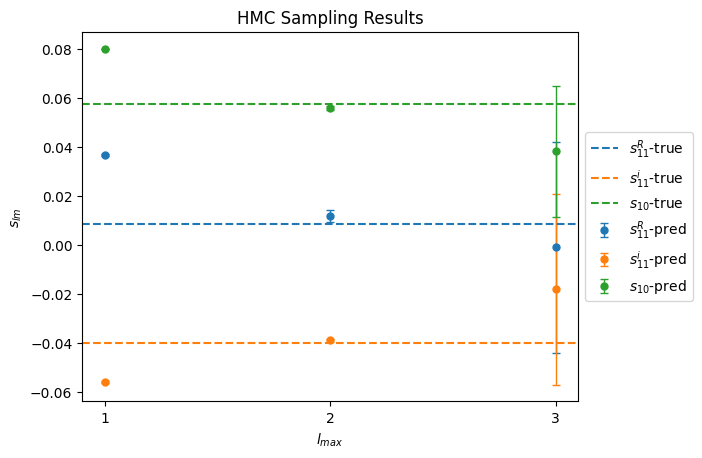

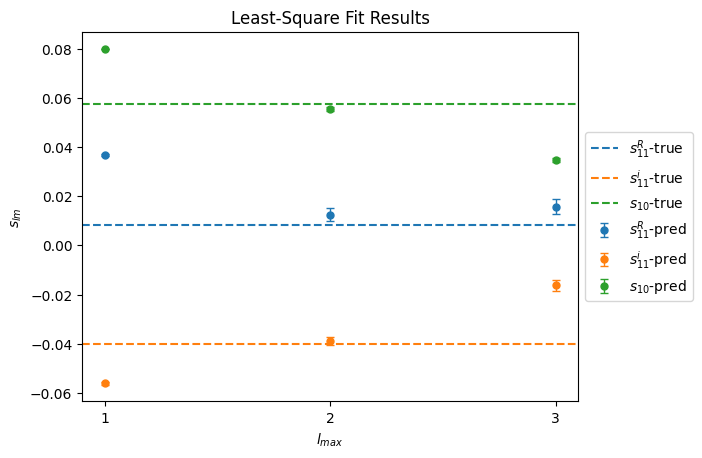

In [69]:
import matplotlib.pyplot as plt

# HMC
lmax_values = [1,2,3]

s10_hmc, er10_hmc = [coef_pred[z][1] for z in range(0,3)], [std_pred[z][1] for z in range(0,3)]
s11r_hmc, er11r_hmc = [coef_pred[x][4] for x in range(0,3)], [std_pred[x][4] for x in range(0,3)]
s11i_hmc, er11i_hmc = [coef_pred[y][5] for y in range(0,3)], [std_pred[y][5] for y in range(0,3)]


plt.errorbar(lmax_values, s11r_hmc, yerr=er11r_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^{R}$-pred')
plt.errorbar(lmax_values, s11i_hmc, yerr=er11i_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^i$-pred')
plt.errorbar(lmax_values, s10_hmc, yerr=er10_hmc, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{10}$-pred')

plt.axhline(vsh_coeff_gen[4], linestyle='--', color='tab:blue', label=r'$s_{11}^{R}$-true')
plt.axhline(vsh_coeff_gen[5], linestyle='--', color='tab:orange', label=r'$s_{11}^{i}$-true')
plt.axhline(vsh_coeff_gen[1], linestyle='--', color='tab:green', label=r'$s_{10}$-true')

plt.title("HMC Sampling Results")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'$s_{lm}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.savefig("plots/plots_test/hmc_on_fake_data.png", dpi=300, bbox_inches='tight')
plt.show()

# Least-Square

s10_ls, er10_ls = [fitted_thetas[z][1] for z in range(0,3)], [std_theta_fit[z][1] for z in range(0,3)]
s11r_ls, er11r_ls = [fitted_thetas[x][4] for x in range(0,3)], [std_theta_fit[x][4] for x in range(0,3)]
s11i_ls, er11i_ls = [fitted_thetas[y][5] for y in range(0,3)], [std_theta_fit[y][5] for y in range(0,3)]


plt.errorbar(lmax_values, s11r_ls, yerr=er11r_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^{R}$-pred')
plt.errorbar(lmax_values, s11i_ls, yerr=er11i_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{11}^i$-pred')
plt.errorbar(lmax_values, s10_ls, yerr=er10_ls, fmt='o', capsize=3, markersize=5, elinewidth=1, label=r'$s_{10}$-pred')

plt.axhline(vsh_coeff_gen[4], linestyle='--', color='tab:blue', label=r'$s_{11}^{R}$-true')
plt.axhline(vsh_coeff_gen[5], linestyle='--', color='tab:orange', label=r'$s_{11}^{i}$-true')
plt.axhline(vsh_coeff_gen[1], linestyle='--', color='tab:green', label=r'$s_{10}$-true')

plt.title("Least-Square Fit Results")
plt.xlabel(r'$l_{max}$')
plt.ylabel(r'$s_{lm}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(lmax_values)
plt.savefig("plots/plots_test/iminuit_on_fake_data.png", dpi=300, bbox_inches='tight')
plt.show()

In [47]:
def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-0.08, 0.08).expand([total_params]))

    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = least_square(angles, obs, error, theta, lmax=lmax, grid=False)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

In [ ]:


def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])


def model_for_HMC(angles, obs, error, lmax):
    total_params = count_vsh_coeffs(lmax)
    theta = numpyro.sample("theta", dist.Uniform(-0.08, 0.08).expand([total_params]))
    chi2_val = chi2_jit(angles, obs, error, theta, lmax) 
    numpyro.factor("likelihood", -0.5*chi2_val)


In [55]:
posterior_samples = []
rng_key = jax.random.key(0)

kernel = NUTS(model_for_HMC, target_accept_prob=0.75)
mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)

angles_gen_jnp = jnp.array(angles_gen)
obs_gen_jnp = jnp.array(obs_gen)
error_gen_jnp = jnp.array(error_gen)

for i in range(1,4):
    
    mcmc.run(rng_key, angles=angles_gen_jnp, obs=obs_gen_jnp, error=error_gen_jnp, lmax=i)
    posterior_sample = mcmc.get_samples()
    
    posterior_samples.append(posterior_sample)

/tmp/ipykernel_22239/3319190644.py:5: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=100, num_samples=2000, num_chains=2, progress_bar=True)
sample:  98%|█████████▊| 2048/2100 [04:05<00:06,  8.34it/s, 127 steps of size 3.16e-02. acc. prob=0.87]


KeyboardInterrupt: 